In [1]:
# Set spark environments
import os
import sys
#os.environ["SPARK_HOME"] = '/home/ypang6/anaconda3/lib/python3.7/site-packages/pyspark'
#os.environ["PYTHONPATH"] = '/home/ypang6/anaconda3/bin/python3.7'
#os.environ['PYSPARK_PYTHON'] = '/home/ypang6/anaconda3/bin/python3.7'
#os.environ['PYSPARK_DRIVER_PYTHON'] = '/home/ypang6/anaconda3/bin/python3.7'
os.environ["SPARK_HOME"]="/usr/local/spark"
os.environ["PYLIB"]=os.environ["SPARK_HOME"]+"/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.9-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")
os.environ["PYSPARK_PYTHON"] = "/home/anaconda3/bin/python" 
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master local[2] pyspark-shell "

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
#####
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql import Window
#####

In [3]:
spark = SparkSession \
        .builder \
        .appName("Terminal_Area_Flight_Data_Query") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

# recType3 Data
## Custom schema of the data
### References to IFF_2.15_Specs_Sherlock.doc

In [4]:
myschema = StructType([
    StructField("recType", ShortType(), True),  #1  //track point record type number
    StructField("recTime", StringType(), True),  #2  //seconds since midnigght 1/1/70 UTC
    StructField("fltKey", LongType(), True),  #3  //flight key
    StructField("bcnCode", IntegerType(), True),  #4  //digit range from 0 to 7
    StructField("cid", IntegerType(), True),  #5  //computer flight id
    StructField("Source", StringType(), True),  #6  //source of the record 
    StructField("msgType", StringType(), True),  #7
    StructField("acId", StringType(), True),  #8  //call sign
    StructField("recTypeCat", StringType(), True),  #9
    StructField("lat", DoubleType(), True),  #10
    StructField("lon", DoubleType(), True),  #11 
    StructField("alt", DoubleType(), True),  #12  //in 100s of feet
    StructField("significance", ShortType(), True),  #13 //digit range from 1 to 10
    StructField("latAcc", DoubleType(), True),  #14
    StructField("lonAcc", DoubleType(), True),  #15
    StructField("altAcc", DoubleType(), True),  #16
    StructField("groundSpeed", IntegerType(), True),  #17 //in knots
    StructField("course", DoubleType(), True),  #18  //in degrees from true north
    StructField("rateOfClimb", DoubleType(), True),  #19  //in feet per minute
    StructField("altQualifier", StringType(), True),  #20  //Altitude qualifier (the “B4 character”)
    StructField("altIndicator", StringType(), True),  #21  //Altitude indicator (the “C4 character”)
    StructField("trackPtStatus", StringType(), True),  #22  //Track point status (e.g., ‘C’ for coast)
    StructField("leaderDir", IntegerType(), True),  #23  //int 0-8 representing the direction of the leader line
    StructField("scratchPad", StringType(), True),  #24
    StructField("msawInhibitInd", ShortType(), True),  #25 // MSAW Inhibit Indicator (0=not inhibited, 1=inhibited)
    StructField("assignedAltString", StringType(), True),  #26 
    StructField("controllingFac", StringType(), True),  #27
    StructField("controllingSec", StringType(), True),  #28
    StructField("receivingFac", StringType(), True),  #29
    StructField("receivingSec", StringType(), True),  #30
    StructField("activeContr", IntegerType(), True),  #31  // the active control number
    StructField("primaryContr", IntegerType(), True),  #32  //The primary(previous, controlling, or possible next)controller number
    StructField("kybrdSubset", StringType(), True),  #33  //identifies a subset of controller keyboards
    StructField("kybrdSymbol", StringType(), True),  #34  //identifies a keyboard within the keyboard subsets
    StructField("adsCode", IntegerType(), True),  #35  //arrival departure status code
    StructField("opsType", StringType(), True),  #36  //Operations type (O/E/A/D/I/U)from ARTS and ARTS 3A data
    StructField("airportCode", StringType(), True),  #37 
    StructField("trackNumber", IntegerType(), True),  #38
    StructField("tptReturnType", StringType(), True),  #39
    StructField("modeSCode", StringType(), True),  #40
    StructField("sensorTrackNumberList", StringType(), True), #41 //a list of sensor/track number combinations
    StructField("spi", StringType(), True),  #42 // representing the Ident feature
    StructField("dvs", StringType(), True), #43 // indicate the aircraft is within a suppresion volumn area
    StructField("dupM3a", StringType(), True),  #44 // indicate 2 aircraft have the same mode 3a code
    StructField("tid", StringType(), True),  #45 //Aircraft Ident entered by pilot

])

In [5]:
date = 20190801

In [6]:
import glob
file_path = glob.glob("/home/pzhao28/Documents/Research/Software/sequencing and deconflict/arrival_time_prediction/PySparkGeoSparkDemo-main/data")[0]

In [7]:
df = spark.read.csv(file_path, header=False, sep=",", schema=myschema)

In [8]:
df.printSchema()

root
 |-- recType: short (nullable = true)
 |-- recTime: string (nullable = true)
 |-- fltKey: long (nullable = true)
 |-- bcnCode: integer (nullable = true)
 |-- cid: integer (nullable = true)
 |-- Source: string (nullable = true)
 |-- msgType: string (nullable = true)
 |-- acId: string (nullable = true)
 |-- recTypeCat: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- alt: double (nullable = true)
 |-- significance: short (nullable = true)
 |-- latAcc: double (nullable = true)
 |-- lonAcc: double (nullable = true)
 |-- altAcc: double (nullable = true)
 |-- groundSpeed: integer (nullable = true)
 |-- course: double (nullable = true)
 |-- rateOfClimb: double (nullable = true)
 |-- altQualifier: string (nullable = true)
 |-- altIndicator: string (nullable = true)
 |-- trackPtStatus: string (nullable = true)
 |-- leaderDir: integer (nullable = true)
 |-- scratchPad: string (nullable = true)
 |-- msawInhibitInd: short (nullable = true)
 |

### Select Columns

In [9]:
cols = ['recType', 'recTime', 'acId', 'lat', 'lon', 'alt', 'groundSpeed']
df_rec3 = df.select(*cols).filter(df['recType']==3).withColumn("recTime", df['recTime'].cast(IntegerType()))

In [10]:
df_rec3.show()

+-------+----------+-----+--------+---------+----+-----------+
|recType|   recTime| acId|     lat|      lon| alt|groundSpeed|
+-------+----------+-----+--------+---------+----+-----------+
|      3|1564634988|SKQ74|36.10444|-79.43917|23.0|        200|
|      3|1564634999|SKQ74|36.11417|-79.43611|26.0|        200|
|      3|1564635012|SKQ74|36.12389| -79.4325|29.0|        171|
|      3|1564635024|SKQ74|36.13333|-79.42889|32.0|        180|
|      3|1564635036|SKQ74|36.14278|-79.42583|37.0|        178|
|      3|1564635048|SKQ74| 36.1525|-79.42278|40.0|        183|
|      3|1564635059|SKQ74|36.16083|   -79.42|43.0|        172|
|      3|1564635072|SKQ74|36.17139|-79.41667|46.0|        184|
|      3|1564635084|SKQ74|36.18056|-79.41389|48.0|        172|
|      3|1564635096|SKQ74|36.19028|-79.41056|51.0|        184|
|      3|1564635108|SKQ74|    36.2|-79.40722|54.0|        184|
|      3|1564635120|SKQ74|   36.21|-79.40389|58.0|        189|
|      3|1564635132|SKQ74|36.21944|-79.40056|60.0|     

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

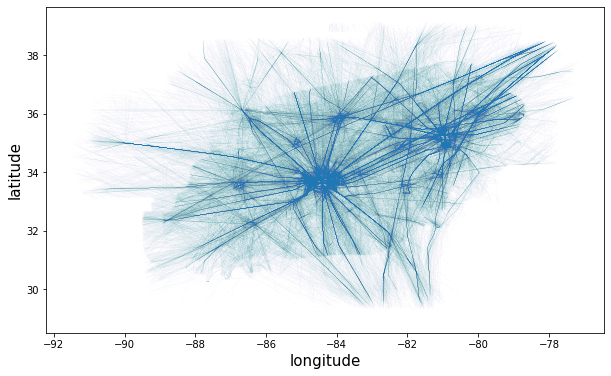

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
pdf_rec3 = df_rec3.toPandas()
plt.scatter(pdf_rec3['lon'], pdf_rec3['lat'],  s=0.00001)
plt.xlabel('longitude',fontsize=15)
plt.ylabel('latitude',fontsize=15)
fig.savefig('sector')

# recType2 data

In [13]:
from pkg_resources.extern import packaging

def parse_version(v):
    try:
        return packaging.version.Version(v)
    except packaging.version.InvalidVersion:
        return packaging.version.LegacyVersion(v)

In [14]:
def read_iff_file(filename, record_types=3, callsigns=None, chunksize=50000, encoding='latin-1'):
    """
    Read IFF file and return data frames for requested record types
    
    From IFF 2.15 specification, record types include:
    2. header
    3. track point
    4. flight plan
    5. data source program
    6. sectorization
    7. minimum safe altitude
    8. flight progress
    9. aircraft state
    Parameters
    ----------
    filename : str
        File to read
    record_types : int, sequence of ints, or 'all'
        Record types to return
    callsigns : None, string, or list of strings
        If None, return records for all aircraft callsigns.
        Otherwise, only return records that match the given callsign
        (in the case of a single string) or match one of the specified
        callsigns (in the case of a list of strings).
    chunksize: int
        Number of rows that are read at a time by pd.read_csv.  This
        limits memory usage when working with large files, as we can
        extract out the desired rows from each chunk, intead of
        reading everything into one large DataFrame and then taking a
        subset.
    encoding: str
        Encoding argument passed on to open and pd.read_csv.  Using
        'latin-1' instead of the default will suppress errors that
        might otherwise occur with minor data corruption.  See
        http://python-notes.curiousefficiency.org/en/latest/python3/text_file_processing.html
    
    Returns
    -------
    DataFrame or dict of DataFrames
       If record_types is a scalar, return a DataFrame containing the
       data for that record type only.  Otherwise, return a dictionary
       mapping each requested record type to a corresponding DataFrame.
    """
    # Note default record_type of 3 (track point) is used for
    # consistency with the behavior of other functions that expect
    # flight tracking data

    # Determine file format version.  This is in record type 1, which
    # for now we assume to occur on the first line.
    with open(filename, 'r') as f:
        version = parse_version(f.readline().split(',')[2])

    # Columns for each record type, from version 2.6 specification.
    cols = {0:['recType','comment'],
            1:['recType','fileType','fileFormatVersion'],
            2:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','acType','Orig','Dest','opsType','estOrig','estDest'],
            3:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','coord1','coord2','alt','significance','coord1Accur','coord2Accur','altAccur','groundSpeed','course','rateOfClimb','altQualifier','altIndicator','trackPtStatus','leaderDir','scratchPad','msawInhibitInd','assignedAltString','controllingFac','controllingSeg','receivingFac','receivingSec','activeContr','primaryContr','kybrdSubset','kybrdSymbol','adsCode','opsType','airportCode'],
            4:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','acType','Orig','Dest','altcode','alt','maxAlt','assignedAltString','requestedAltString','route','estTime','fltCat','perfCat','opsType','equipList','coordinationTime','coordinationTimeType','leaderDir','scratchPad1','scratchPad2','fixPairScratchPad','prefDepArrRoute','prefDepRoute','prefArrRoute'],
            5:['recType','dataSource','programName','programVersion'],
            6:['recType','recTime','Source','msgType','rectypeCat','sectorizationString'],
            7:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','coord1','coord2','alt','significance','coord1Accur','coord2Accur','altAccur','msawtype','msawTimeCat','msawLocCat','msawMinSafeAlt','msawIndex1','msawIndex2','msawVolID'],
            8:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','acType','Orig','Dest','depTime','depTimeType','arrTime','arrTimeType'],
            9:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','coord1','coord2','alt','pitchAngle','trueHeading','rollAngle','trueAirSpeed','fltPhaseIndicator'],
            10:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','configType','configSpec']}

    # For newer versions, additional columns are supported.  However,
    # this code could be commented out, and it should still be
    # compatible with newer versions, but just ignoring the additional
    # columns.
    if version >= parse_version('2.13'):
        cols[2] += ['modeSCode']
        cols[3] += ['trackNumber','tptReturnType','modeSCode']
        cols[4] += ['coordinationPoint','coordinationPointType','trackNumber','modeSCode']
    if version >= parse_version('2.15'):
        cols[3] += ['sensorTrackNumberList','spi','dvs','dupM3a','tid']

    # Determine the record type of each row
    with open(filename, 'r', encoding=encoding) as f:
        # An alternative, using less memory, would be to directly
        # create skiprows indices for a particular record type, using
        # a comprehension on enumerate(f); however, that would not
        # allow handling multiple record types.
        line_record_types = [int(line.split(',')[0]) for line in f]

    # Determine which record types to retrieve, and whether the result
    # should be a scalar or dict:
    if record_types == 'all':
        record_types = np.unique(line_record_types)
        scalar_result = False
    elif hasattr(record_types, '__getitem__'):
        scalar_result = False
    else:
        record_types = [record_types]
        scalar_result = True

    if callsigns is not None:
        callsigns = list(np.atleast_1d(callsigns))


    data_frames = dict()
    for record_type in record_types:
        # Construct list of rows to skip:
        skiprows = [i for i,lr in enumerate(line_record_types) if lr != record_type]
        
        # Passing usecols is necessary because for some records, the
        # actual data has extraneous empty columns at the end, in which
        # case the data does not seem to get read correctly without
        # usecols
        if callsigns is None:
            df = pd.concat((chunk for chunk in pd.read_csv(filename, header=None, skiprows=skiprows, names=cols[record_type], usecols=cols[record_type], na_values='?', encoding=encoding, chunksize=chunksize, low_memory=False)), ignore_index=True)
        else:
            df = pd.concat((chunk[chunk['AcId'].isin(callsigns)] for chunk in pd.read_csv(filename, header=None, skiprows=skiprows, names=cols[record_type], usecols=cols[record_type], na_values='?', encoding=encoding, chunksize=chunksize, low_memory=False)), ignore_index=True)

        # For consistency with other PARA-ATM data:
        df.rename(columns={'recTime':'time',
                           'AcId':'callsign',
                           'coord1':'latitude',
                           'coord2':'longitude',
                           'alt':'altitude',
                           'rateOfClimb':'rocd',
                           'groundSpeed':'tas',
                           'course':'heading'},
                  inplace=True)

        #if 'time' in df:
            #df['time'] = pd.to_datetime(df['time'], unit='s')
        if 'altitude' in df:
            df['altitude'] *= 100 # Convert 100s ft to ft

        # Store to dict of data frames
        data_frames[record_type] = df

    if scalar_result:
        result = data_frames[record_types[0]]
    else:
        result = data_frames

    return result

In [15]:
file_path

'/home/pzhao28/Documents/Research/Software/sequencing and deconflict/arrival_time_prediction/PySparkGeoSparkDemo-main/data'

In [16]:
file_names = ['/IFF_ZTL_20190801.csv', '/IFF_ZTL_20190802_050043_86336.csv']
pd_df_rec2 = pd.DataFrame() 
for file_name in file_names:
    pd_df_rec2_tmp = pd.DataFrame()
    pd_df_rec2_tmp = read_iff_file(file_path+file_name, record_types=2, chunksize = 1e6)
    pd_df_rec2 = pd.concat([pd_df_rec2, pd_df_rec2_tmp])
#pd_df_rec2 = read_iff_file(file_path, record_types=2, chunksize = 1e6)

In [17]:
cols_rec2 = ['recType', 'time', 'callsign', 'acType', 'Orig', 'Dest']
pd_df_2 = pd_df_rec2[['recType', 'time', 'callsign', 'acType', 'Orig', 'Dest']]

In [18]:
#t = pd.to_datetime(1561350792, format='%Y%m%d')

In [19]:
pd_df_2.head()

,recType,time,callsign,acType,Orig,Dest
0,2,1.564635e+09,SKQ74,PC12,KBUY,KIAD
1,2,1.564633e+09,DAL2681,A321,KATL,KRDU
2,2,1.564632e+09,LN441PC,LJ35,OTK337060,KGBG
3,2,1.564632e+09,DAL2690,B752,37.016667/-80.383333,KATL
4,2,1.564632e+09,UPS9603,B752,ATL130032,KSDF


# Data Processing

In [20]:
pd.options.display.max_rows = 1000

In [21]:
### pandas
pdf_rec3['next_acId'] = pdf_rec3['acId'].shift(-1)
pdf_rec3['previous_acId'] = pdf_rec3['acId'].shift(1)
pdf_rec3['init_ac'] = pdf_rec3['acId'] != pdf_rec3['previous_acId']
pdf_rec3['end_ac'] = pdf_rec3['acId'] != pdf_rec3['next_acId']
pdf_rec3.drop(columns=['previous_acId', 'next_acId'])

,recType,recTime,acId,lat,lon,alt,groundSpeed,init_ac,end_ac
0,3,1564634988,SKQ74,36.10444,-79.43917,23.0,200,True,False
1,3,1564634999,SKQ74,36.11417,-79.43611,26.0,200,False,False
2,3,1564635012,SKQ74,36.12389,-79.43250,29.0,171,False,False
3,3,1564635024,SKQ74,36.13333,-79.42889,32.0,180,False,False
4,3,1564635036,SKQ74,36.14278,-79.42583,37.0,178,False,False
...,...,...,...,...,...,...,...,...,...
3982681,3,1564721673,FDX105,34.18667,-87.98472,309.0,449,False,False
3982682,3,1564721685,FDX105,34.19889,-88.01111,304.0,453,False,False
3982683,3,1564721697,FDX105,34.21139,-88.03750,300.0,455,False,False
3982684,3,1564721709,FDX105,34.22389,-88.06389,295.0,455,False,False


In [22]:
### pyspark
Windowspec=Window.orderBy("recType")
df_rec3 = df_rec3.withColumn('prev_acId', F.lag(df_rec3['acId']).over(Windowspec))
df_rec3 = df_rec3.withColumn('next_acId', F.lead(df_rec3['acId']).over(Windowspec))
df_rec3 = df_rec3.withColumn('init_ac', F.when(df_rec3.acId == df_rec3.prev_acId, False).otherwise(True))
df_rec3 = df_rec3.withColumn('end_ac', F.when(df_rec3.acId == df_rec3.next_acId, False).otherwise(True))
df_rec3 = df_rec3.withColumn('index', F.row_number().over(Windowspec))
df_rec3.drop('prev_acId')
cols = ['index','recType', 'recTime', 'acId', 'lat', 'lon', 'alt', 'groundSpeed', 'init_ac', 'end_ac']

In [23]:
ZTL_airports = ['KATL', 'KCHA', 'KGSO', 'KGSP', 'KHKY', 'KHSV']
airportsCoord = {'KATL':(33.6407, -84.4277), \
                 'KCHA':(35.0374, -85.1970), \
                 'KSGO':(36.1044, -79.9352), \
                 'KGSP':(34.8959, -82.2172), \
                 'KHKY':(35.7422, -81.3893), \
                 'KHSV':(34.6403, -86.7757)}

## extract arrival

In [24]:
schema = StructType([
    StructField('time', StringType(), True),
    StructField('hour', StringType(), True),
    StructField('acId', StringType(), True),
    StructField('lat', DoubleType(), True),
    StructField('lon', DoubleType(), True),
    StructField('alt', DoubleType(), True),
    StructField('Dest', StringType(), True),
    StructField('acType', StringType(), True),
    StructField('arr_time', StringType(), True)
    #StructField('time_100', StringType(), True),
    #StructField('time_40', StringType(), True)
])

In [25]:
import numpy as np

def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    m = 6367 * dist * 1000 #6367 for distance in KM for miles use 3958
    return m

In [26]:
circl200 = 370400
out_circl = 370400/2
in_circl = 74080

In [27]:
out_circl

185200.0

In [28]:
def num_ac_ahead(current_time, dest, data = pdf_rec3):
    tmp_data = data.loc[data['recTime'].between(current_time-600, current_time)]
    tmp_data.loc[:,'distance'] = haversine_vectorize(tmp_data['lon'], tmp_data['lat'], airportsCoord[dest][1], airportsCoord[dest][0])
    return len(tmp_data.loc[tmp_data['distance'].between(in_circl, out_circl)]['acId'].unique())

In [29]:
def num_ac_behind(current_time, dest, data = pdf_rec3):
    tmp_data = data.loc[data['recTime'].between(current_time, current_time+600)]
    tmp_data.loc[:,'distance'] = haversine_vectorize(tmp_data['lon'], tmp_data['lat'], airportsCoord[dest][1], airportsCoord[dest][0])
    return len(tmp_data.loc[tmp_data['distance'].between(in_circl, out_circl)]['acId'].unique())

In [30]:
### pandas
columns = ['recTime', 'time','hour','acId', 'lat', 'lon', 'alt', 'Dest','distance', 'acType','groundSpeed', 'num_ac_ahead', 'num_ac_behind', 'arr_time', 'time200','time100','time40']
pdf3 = pd.DataFrame([], columns=columns)
for index, row in pdf_rec3.iterrows():
    if row['init_ac']:
        init_index = index
        timestamp = row.recTime
    if row.end_ac:
        if row.alt <= 50:
            end_index = index
            tmp_pdf = pdf_rec3.iloc[init_index:end_index+1, :]
            tmp_dest = pd_df_2[pd_df_2['time']==timestamp]['Dest'].to_string(index=False).strip()
            acType = pd_df_2[pd_df_2['time']==timestamp]['acType'].to_string(index=False).strip()
            if tmp_dest in airportsCoord.keys():
                tmp_pdf.loc[:,'Dest'] = tmp_dest
                tmp_pdf.loc[:,'acType'] = acType
                tmp_pdf.loc[:,'dest_lat'] = airportsCoord[tmp_dest][0]
                tmp_pdf.loc[:,'dest_lon'] = airportsCoord[tmp_dest][1]
                tmp_pdf.loc[:,'distance'] = haversine_vectorize(tmp_pdf['lon'], tmp_pdf['lat'], tmp_pdf['dest_lon'], tmp_pdf['dest_lat'])
                #tmp_pdf = tmp_pdf[tmp_pdf['distance'] <= 185200]
                tmp_pdf = tmp_pdf.loc[tmp_pdf['distance'] <= circl200]
                tmp_pdf.loc[:,'time200'] = tmp_pdf.head(1)['recTime'].values
                tmp_pdf_200 = tmp_pdf.loc[tmp_pdf['distance'].between(circl200 - 20000, circl200)]
                #print(tmp_pdf.head(1)['recTime'].values)
                tmp_pdf = tmp_pdf.loc[tmp_pdf['distance'] <= out_circl]
                tmp_pdf = tmp_pdf.loc[tmp_pdf['distance'] >= in_circl]
                tmp_pdf_out = tmp_pdf.loc[tmp_pdf['distance'].between(out_circl - 20000, out_circl)]
                tmp_pdf_in = tmp_pdf.loc[tmp_pdf['distance'].between(in_circl,in_circl + 20000)]
                if not tmp_pdf_in.empty and not tmp_pdf_out.empty and not tmp_pdf_200.empty:
                    tmp_time = pd.to_datetime(tmp_pdf.head(1)['recTime'].values[0]-14400, unit='s')
                    tmp_pdf.loc[:,'time'] = tmp_time
                    #tmp_pdf.loc[:,'time'] = tmp_pdf.head(1)['recTime']
                    tmp_pdf.loc[:,'hour'] = tmp_time.hour
                    in_time = tmp_pdf.head(1)['recTime'].values[0]
                    out_time = tmp_pdf.tail(1)['recTime'].values[0]
                    center_time = tmp_pdf.loc[tmp_pdf['distance'].between(out_circl/2-100000, out_circl/2)].head(1)['recTime'].values[0]
                    tmp_pdf.loc[:,'arr_time'] = out_time - in_time#out_time - center_time #in_time
                    tmp_pdf.loc[:,'time40'] = out_time
                    tmp_pdf.loc[:,'time100'] = in_time
                    first_time = tmp_pdf.head(1)['recTime'].values[0]
                    number_ahead = num_ac_ahead(in_time, tmp_dest)
                    number_behind = num_ac_behind(in_time, tmp_dest)
                    tmp_pdf.loc[:,'num_ac_ahead'] = number_ahead
                    tmp_pdf.loc[:,'num_ac_behind'] = number_behind
                    #print('time200:{}'.format(tmp_pdf[tmp_pdf['recTime']==first_time]['time200'].values))
                    #print('\n')
                    #print('time100:{}'.format(tmp_pdf[tmp_pdf['recTime']==first_time]['time100'].values))
                    pdf3 = pdf3.append(tmp_pdf[tmp_pdf['recTime']==first_time][columns])
                    print("processed aircraft: {}".format(pdf3.shape[0]),end='\r')
                    sys.stdout.flush()


/home/pzhao28/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/pzhao28/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


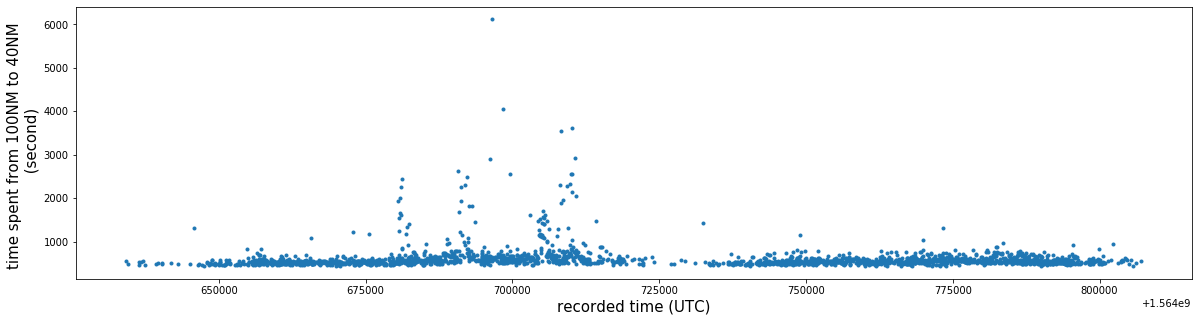

In [31]:
fig, ax = plt.subplots(figsize=(20,5))
arr_t = pdf3['arr_time'].values
time_list = pdf3['recTime'].values
plt.scatter(time_list, arr_t, marker='.')
plt.xlabel('recorded time (UTC)', fontsize=15)
plt.ylabel('time spent from 100NM to 40NM \n (second)', fontsize=15)
fig.savefig('arrival_time')

In [32]:
pdf3.head(100)

,recTime,time,hour,acId,lat,lon,alt,Dest,distance,acType,groundSpeed,num_ac_ahead,num_ac_behind,arr_time,time200,time100,time40
811,1564634536,2019-08-01 00:42:16,0,DAL2690,34.82167,-83.00944,380.0,KATL,184932.301809,B752,426,6,12,483,1564633694,1564634536,1564635019
1300,1564634291,2019-08-01 00:38:11,0,AAL2290,32.45111,-83.06111,271.0,KATL,183515.304206,A319,447,4,8,556,1564633501,1564634291,1564634847
8042,1564636402,2019-08-01 01:13:22,1,SWA2474,32.86306,-86.17028,376.0,KATL,183548.919112,B738,415,17,20,525,1564635585,1564636402,1564636927
8300,1564636436,2019-08-01 01:13:56,1,DAL1777,34.97583,-85.61972,330.0,KATL,184345.466750,B712,484,20,21,470,1564635697,1564636436,1564636906
9515,1564637031,2019-08-01 01:23:51,1,JBU997,34.81389,-82.99806,247.0,KATL,185064.672427,E190,423,21,14,550,1564636190,1564637031,1564637581
9726,1564636844,2019-08-01 01:20:44,1,DAL1491,32.02472,-84.88306,340.0,KATL,184540.206834,B752,497,18,20,539,1564635999,1564636844,1564637383
10926,1564637392,2019-08-01 01:29:52,1,DAL2778,34.79222,-83.01028,360.0,KATL,182585.849830,A320,413,21,10,465,1564636557,1564637392,1564637857
16341,1564639359,2019-08-01 02:02:39,2,DAL2398,34.81806,-83.00472,320.0,KATL,184956.083571,B712,465,8,7,488,1564638554,1564639359,1564639847
16665,1564639583,2019-08-01 02:06:23,2,JBU568,32.44278,-83.08222,303.0,KATL,182833.870151,A320,474,9,7,507,1564638793,1564639583,1564640090
18235,1564640260,2019-08-01 02:17:40,2,DAL2142,34.81583,-83.00750,319.0,KATL,184601.497638,MD90,426,8,8,491,1564639418,1564640260,1564640751


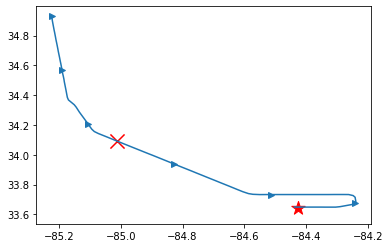

In [33]:
EDV3471_tr = pdf_rec3.loc[pdf_rec3['acId']=='EDV3471']
EDV3471_tr = EDV3471_tr.loc[EDV3471_tr['recTime'].between(1564702750-2000,1564702750+3000)]
plt.plot(EDV3471_tr['lon'], EDV3471_tr['lat'], marker = '>', markevery=20)
plt.scatter(airportsCoord['KATL'][1], airportsCoord['KATL'][0], marker = '*', color='r', s = 200)
for index, row in EDV3471_tr.iterrows():
    distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord['KATL'][1], airportsCoord['KATL'][0])
    if distance2airport<74080:
        plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
        break

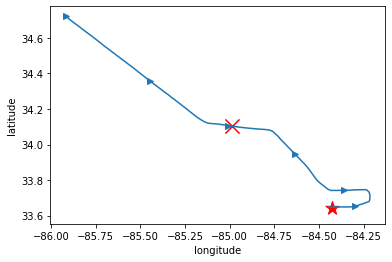

In [34]:
fig, ax = plt.subplots()
DAL2075_tr = pdf_rec3.loc[pdf_rec3['acId']=='DAL2075']
DAL2075_tr = DAL2075_tr.loc[DAL2075_tr['recTime'].between(1564684886,1564684886+3000)]
plt.plot(DAL2075_tr['lon'], DAL2075_tr['lat'], marker = '>', markevery=20)
plt.scatter(airportsCoord['KATL'][1], airportsCoord['KATL'][0], marker = '*', color='r', s = 200)
for index, row in DAL2075_tr.iterrows():
    distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord['KATL'][1], airportsCoord['KATL'][0])
    if distance2airport<74080:
        plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
        break
plt.xlabel('longitude')
plt.ylabel('latitude')
fig.savefig('tr_normal')

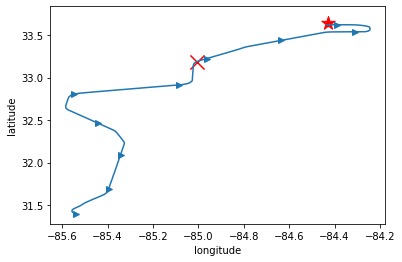

In [35]:
fig, ax = plt.subplots()
SKW3899_tr = pdf_rec3.loc[pdf_rec3['acId']=='SKW3899']
SKW3899_tr = SKW3899_tr.loc[SKW3899_tr['recTime'].between(1564688772-1000,1564688772+3000)]
plt.plot(SKW3899_tr['lon'], SKW3899_tr['lat'], marker = '>', markevery=20)
plt.scatter(airportsCoord['KATL'][1], airportsCoord['KATL'][0], marker = '*', color='r', s = 200)
for index, row in SKW3899_tr.iterrows():
    distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord['KATL'][1], airportsCoord['KATL'][0])
    if distance2airport<74080:
        plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
        break
plt.xlabel('longitude')
plt.ylabel('latitude')
fig.savefig('tr_mild')

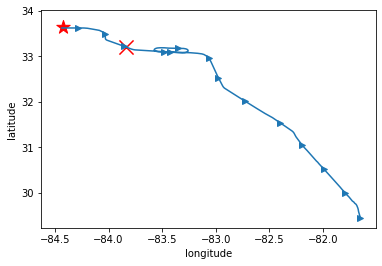

In [36]:
fig, ax = plt.subplots()
DAL1827_tr = pdf_rec3.loc[pdf_rec3['acId']=='DAL1827']
DAL1827_tr = DAL1827_tr.loc[DAL1827_tr['recTime'].between(1564688880,1564688880+5000)]
plt.plot(DAL1827_tr['lon'], DAL1827_tr['lat'], marker = '>', markevery=20)
plt.scatter(airportsCoord['KATL'][1], airportsCoord['KATL'][0], marker = '*', color='r', s = 200)
for index, row in DAL1827_tr.iterrows():
    distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord['KATL'][1], airportsCoord['KATL'][0])
    if distance2airport<74080:
        plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
        break
plt.xlabel('longitude')
plt.ylabel('latitude')
fig.savefig('tr_moderate')

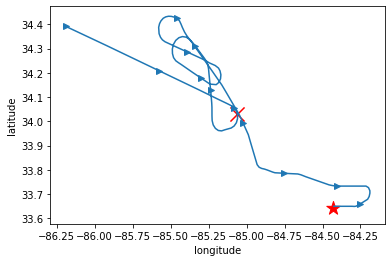

In [37]:
fig, ax = plt.subplots()
SWA1289_tr = pdf_rec3.loc[pdf_rec3['acId']=='SWA1289']
SWA1289_tr = SWA1289_tr.loc[SWA1289_tr['recTime'].between(1564680604,1564680604+3000)]
plt.plot(SWA1289_tr['lon'], SWA1289_tr['lat'], marker = '>', markevery=20)
plt.scatter(airportsCoord['KATL'][1], airportsCoord['KATL'][0], marker = '*', color='r', s = 200)
for index, row in SWA1289_tr.iterrows():
    distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord['KATL'][1], airportsCoord['KATL'][0])
    if distance2airport<74080:
        plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
        break
plt.xlabel('longitude')
plt.ylabel('latitude')
fig.savefig('tr_severe')

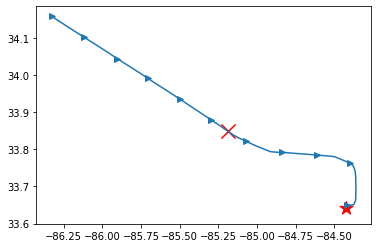

In [38]:
id = 'BVN8515'
tr = pdf_rec3.loc[pdf_rec3['acId']==id]
pdf3_ac = pdf3.loc[pdf3['acId']==id]
pdf3_ac = pdf3_ac.head(1)
time = pdf3_ac['recTime'].values[0]
dest = pdf3_ac['Dest'].values[0]
tr = tr.loc[tr['recTime'].between(time,time+6000)]
plt.plot(tr['lon'], tr['lat'], marker = '>', markevery=20)
plt.scatter(airportsCoord[dest][1], airportsCoord[dest][0], marker = '*', color='r', s = 200)
for index, row in tr.iterrows():
    distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord[dest][1], airportsCoord[dest][0])
    if distance2airport<74080:
        plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
        break

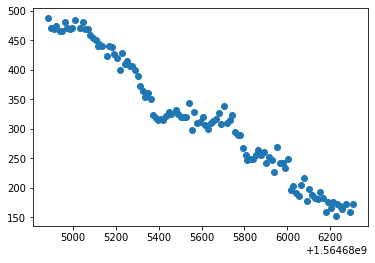

In [39]:
id = 'DAL2075'
tr = pdf_rec3.loc[pdf_rec3['acId']==id]
pdf3_ac = pdf3.loc[pdf3['acId']==id]
pdf3_ac = pdf3_ac.head(1)
time = pdf3_ac['recTime'].values[0]
dest = pdf3_ac['Dest'].values[0]
tr = tr.loc[tr['recTime'].between(time,time+6000)]
plt.scatter( tr['recTime'], tr['groundSpeed'])

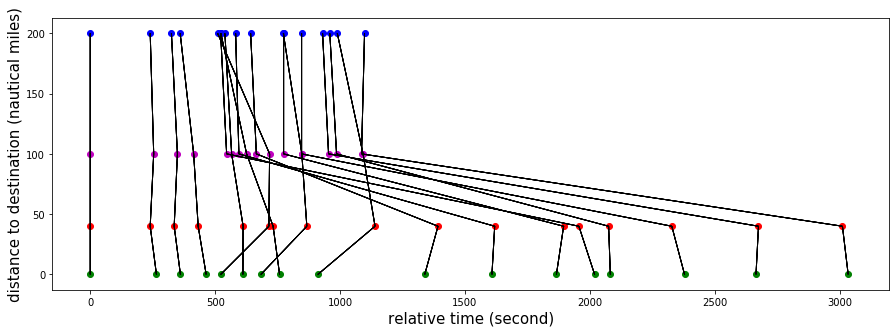

In [40]:
time_interval = [1.5646e9+80000,1.5646e9+81500]#[1.5646e9+75000,1.5646e9+76500]#
busy = pdf3.loc[pdf3['recTime'].between(time_interval[0],time_interval[1])]
busy_runway1 = []
land_t = []

for index, row in busy.iterrows():
    acTr = pdf_rec3.loc[pdf_rec3['acId']==row['acId']]
    end_row = acTr.loc[acTr['end_ac']==True]
    check = end_row.loc[end_row['lat'].between(33.64, 33.65)]
    check = check.loc[check['recTime'].between(time_interval[0],time_interval[1]+3600)]
    if check.empty:
        continue
    busy_runway1.append(row['acId'])
    end_rows = acTr.loc[check.index[0]-20:check.index[0]]
    end_rows = end_rows.loc[end_rows['alt']==check['alt'].values[0]]
    land_t.append(end_rows.head(1)['recTime'].values[0])
    
busy = busy[busy['acId'].isin(busy_runway1)]
busy['land_t'] = land_t
fig, ax = plt.subplots(figsize=(15,5))
#plt.scatter(busy['recTime']-min(busy['recTime']),np.zeros(len(busy)), marker = '.')
#plt.scatter(busy['recTime'], busy['arr_time'])
#plt.scatter(busy['time40']-min(busy['time40']), np.ones(len(busy)), marker = '.')
time200 = busy['time200'].copy()
time100 = busy['time100'].copy()
time40 = busy['time40'].copy()
time0 = busy['land_t'].copy()
for i, time in enumerate(time200):
    time200_tmp = time-min(time200)
    time100_tmp = time100.values[i]-min(time100)
    time40_tmp = time40.values[i]-min(time40)
    time0_tmp = time0.values[i] - min(time0)
    ax.scatter(time200_tmp,200,marker='o', color='b')
    ax.scatter(time100_tmp,100,marker='o', color='m')
    ax.scatter(time40_tmp,40,marker='o', color='r')
    ax.scatter(time0_tmp,0,marker='o', color = 'g')
    ar1 = plt.arrow(time200_tmp, 200, time100_tmp-time200_tmp, -100)
    ar2 = plt.arrow(time100_tmp, 100, time40_tmp-time100_tmp, -60)
    ar3 = plt.arrow(time40_tmp, 40, time0_tmp - time40_tmp, -40)
    ax.add_artist(ar1)
    ax.add_artist(ar2)
    ax.add_artist(ar3)
plt.xlabel('relative time (second)', fontsize=15)
plt.ylabel('distance to destination (nautical miles)', fontsize=15)
fig.savefig('truth')

In [41]:
#ind = 1092007#1093325 #1360398 #1779316
#time = pdf3.loc[pdf3.index[:]==ind]['recTime'].values[0]
#slice_data = pdf3[pdf3['recTime'].between(time-15*60,time+120)]
#slice_data = slice_data[slice_data['Dest']=='KATL']
slice_data = busy

In [42]:
slice_data = slice_data.sort_values(by=['time40'])

In [43]:
slice_index = slice_data.index

In [44]:
pdf3=pdf3.drop(index=slice_index)

In [45]:
#pdf3=pdf3.loc[pdf3['arr_time'].between(0,800)]

In [46]:
pdf3 = pdf3.sample(frac=1)

In [47]:
slice_data

,recTime,time,hour,acId,lat,lon,alt,Dest,distance,acType,groundSpeed,num_ac_ahead,num_ac_behind,arr_time,time200,time100,time40,land_t
888680,1564680058,2019-08-01 13:20:58,13,DAL2617,34.92611,-85.70917,283.0,KATL,185058.214234,B712,481,133,141,528,1564679273,1564680058,1564680586,1564681487
888926,1564680312,2019-08-01 13:25:12,13,DAL1524,34.89139,-85.71500,265.0,KATL,182458.971200,B752,464,140,140,514,1564679513,1564680312,1564680826,1564681752
896732,1564680407,2019-08-01 13:26:47,13,SKW3742,34.90611,-85.72972,252.0,KATL,184573.909059,CRJ2,483,141,139,515,1564679598,1564680407,1564680922,1564681848
897317,1564680472,2019-08-01 13:27:52,13,EDV5373,34.80778,-85.86611,253.0,KATL,185164.660008,CRJ7,470,138,136,546,1564679633,1564680472,1564681018,1564681951
907236,1564680624,2019-08-01 13:30:24,13,DAL2846,34.90917,-85.70194,257.0,KATL,183192.074251,MD88,428,138,140,574,1564679812,1564680624,1564681198,1564682098
897880,1564680776,2019-08-01 13:32:56,13,DAL1276,35.13389,-83.56722,240.0,KATL,183736.185160,MD88,428,145,134,525,1564679783,1564680776,1564681301,1564682009
907523,1564680684,2019-08-01 13:31:24,13,DAL2825,34.90139,-85.73028,276.0,KATL,184210.213213,B738,458,141,137,634,1564679796,1564680684,1564681318,1564682245
906736,1564680905,2019-08-01 13:35:05,13,DAL3053,35.15917,-83.63000,220.0,KATL,183908.088833,MD88,384,141,136,548,1564680046,1564680905,1564681453,1564682170
917991,1564681150,2019-08-01 13:39:10,13,DAL2526,35.20250,-83.76111,232.0,KATL,183996.159587,MD88,401,129,131,576,1564680262,1564681150,1564681726,1564682398
926489,1564680723,2019-08-01 13:32:03,13,DAL2463,34.42861,-86.19694,295.0,KATL,184959.609297,MD88,455,141,134,1255,1564679915,1564680723,1564681978,1564682826


In [48]:
''''df3 = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)
cs_arr = []
columns = ['time','partDay','acId', 'lat', 'lon', 'alt', 'Dest', 'acType', 'arr_time']
for row in df_rec3.rdd.collect():
    if row.init_ac:
        init_index = row['index']
        timestamp = row['recTime']
    if row.end_ac:
        if row['alt'] < 100:
            end_index = row['index']
            tmp_df = df_rec3.where(F.col('index').between(init_index, end_index))
            tmp_dest = pd_df_2[pd_df_2['time']==timestamp]['Dest'].to_string(index=False).strip()
            acType = pd_df_2[pd_df_2['time']==timestamp]['acType'].to_string(index=False).strip()
            if tmp_dest in airportsCoord.keys():
                tmp_df = tmp_df.withColumn('Dest', F.lit(tmp_dest))
                tmp_df = tmp_df.withColumn('acType', F.lit(acType))
                tmp_df = tmp_df.withColumn('dest_lat', F.lit(airportsCoord[tmp_dest][0]))
                tmp_df = tmp_df.withColumn('dest_lon', F.lit(airportsCoord[tmp_dest][1]))
                tmp_df = tmp_df.withColumn("a", (F.pow(F.sin(F.radians(F.col("dest_lat") - F.col("lat")) / 2), 2) +\
                                                             F.cos(F.radians(F.col("lat"))) * F.cos(F.radians(F.col("dest_lat"))) *\
                                                             F.pow(F.sin(F.radians(F.col("dest_lon") - F.col("lon")) / 2), 2)\
                                                            )).withColumn("distance", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 12742000) #in meter
                tmp_df = tmp_df.filter(tmp_df['distance']<=185200).filter(tmp_df['distance']>=74080)
                if tmp_df.count() != 0:
                    tmp_time = pd.to_datetime(tmp_df.head(1)[0]['recTime'], unit='s')
                    tmp_df = tmp_df.withColumn('time', F.lit(tmp_time))
                    tmp_df = tmp_df.withColumn('partDay', F.lit(tmp_time.hour//6))
                    #tmp_df = tmp_df.withColumn('time_40', F.lit(tmp_df.tail(1)[0]['recTime']))
                    tmp_df = tmp_df.withColumn('arr_time', F.lit(tmp_df.tail(1)[0]['recTime'] - tmp_df.head(1)[0]['recTime']))
                    first_time = tmp_df.take(1)[0].recTime
                    #tmp = tmp_df.filter(tmp_df['recTime']==first_time).select(*columns)
                    df3 = df3.union(tmp_df.filter(tmp_df['recTime']==first_time).select(*columns))
                    print('number of processed aircraft: {}'.format(df3.count()))
            cs_arr.append(row.acId)'''


'\'df3 = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)\ncs_arr = []\ncolumns = [\'time\',\'partDay\',\'acId\', \'lat\', \'lon\', \'alt\', \'Dest\', \'acType\', \'arr_time\']\nfor row in df_rec3.rdd.collect():\n    if row.init_ac:\n        init_index = row[\'index\']\n        timestamp = row[\'recTime\']\n    if row.end_ac:\n        if row[\'alt\'] < 100:\n            end_index = row[\'index\']\n            tmp_df = df_rec3.where(F.col(\'index\').between(init_index, end_index))\n            tmp_dest = pd_df_2[pd_df_2[\'time\']==timestamp][\'Dest\'].to_string(index=False).strip()\n            acType = pd_df_2[pd_df_2[\'time\']==timestamp][\'acType\'].to_string(index=False).strip()\n            if tmp_dest in airportsCoord.keys():\n                tmp_df = tmp_df.withColumn(\'Dest\', F.lit(tmp_dest))\n                tmp_df = tmp_df.withColumn(\'acType\', F.lit(acType))\n                tmp_df = tmp_df.withColumn(\'dest_lat\', F.lit(airportsCoord[tmp_dest][0]))\n           

In [49]:
'''pdf_rec3_arr = df_rec3_arr.toPandas()
plt.scatter(pdf_rec3_arr['lat'], pdf_rec3_arr['lon'], s=0.00001)'''

"pdf_rec3_arr = df_rec3_arr.toPandas()\nplt.scatter(pdf_rec3_arr['lat'], pdf_rec3_arr['lon'], s=0.00001)"

# Prediction

In [48]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,19 days 4 hours 27 mins
H2O_cluster_timezone:,America/Phoenix
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,2 months and 15 days
H2O_cluster_name:,H2O_from_python_pzhao28_5meo38
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.812 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [49]:
hf = h2o.H2OFrame(pdf3)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [50]:
predictors = ['hour', 'lat', 'lon', 'alt', 'Dest','distance', 'acType', 'groundSpeed', 'num_ac_ahead', 'num_ac_behind','distance']
response = "arr_time"

# split into train and validation sets
train, valid = hf.split_frame(ratios = [.8], seed = 1234)

# train a GBM model
ac_gbm = H2OGradientBoostingEstimator(distribution = "gaussian", seed = 1234)
ac_gbm.train(x = predictors,
               y = response,
               training_frame = train,
               validation_frame = valid)

# retrieve the model performance
perf = ac_gbm.model_performance(valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [51]:
predictors = ['hour', 'lat', 'lon', 'alt', 'Dest','distance', 'acType', 'groundSpeed', 'num_ac_ahead', 'num_ac_behind','distance']
response = "arr_time"

# split into train and validation sets
train, valid = hf.split_frame(ratios = [.8], seed = 1234)

# train a GBM model
ac_gbm = H2OGradientBoostingEstimator(distribution = "gaussian", seed = 1234)
ac_gbm.train(x = predictors,
               y = response,
               training_frame = train,
               validation_frame = valid)

# retrieve the model performance
perf = ac_gbm.model_performance(valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [52]:
pred = ac_gbm.predict(valid)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [53]:
pred

predict
571.594
505.388
645.005
563.008
561.408
493.246
619.316
563.496
651.092
524.978


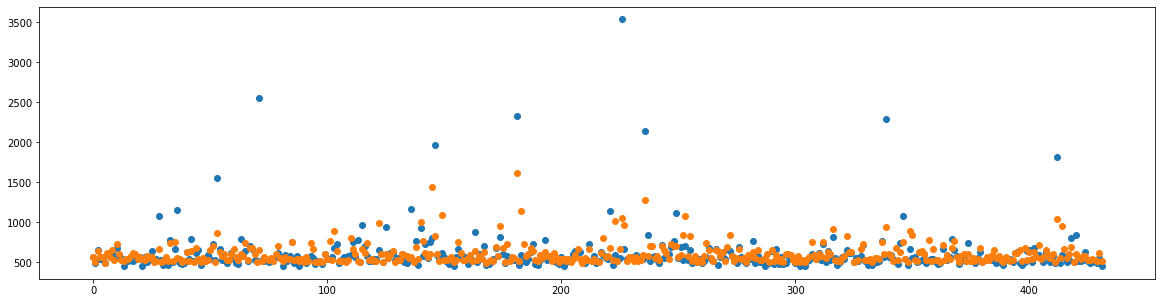

In [54]:
fig, ax = plt.subplots(figsize=(20,5))
validpd = h2o.as_list(valid)
x = np.arange(len(validpd))
plt.scatter(x,validpd['arr_time'].tolist())
predpd = h2o.as_list(pred)
plt.scatter(x,predpd['predict'].tolist())
plt.savefig('result_RF')

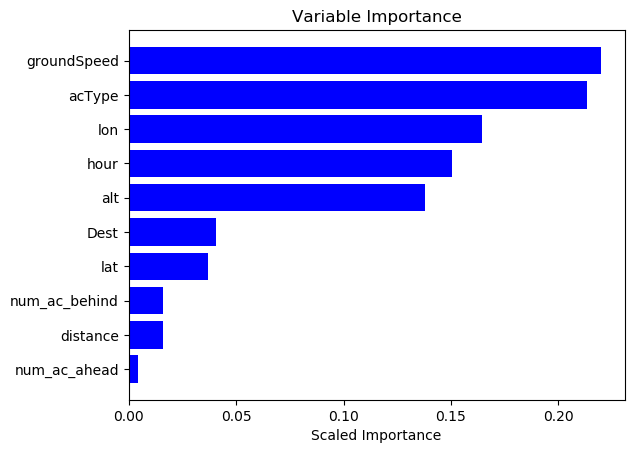

In [55]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = ac_gbm._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = ac_gbm._model_json['output']['variable_importances']['percentage']
ax.barh(y_pos, scaled_importance, align='center', color='blue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

In [56]:
ac_gbm.varimp(True)

,variable,relative_importance,scaled_importance,percentage
0,groundSpeed,80941344.00,1.000000,0.219804
1,acType,78488952.00,0.969702,0.213144
2,lon,60608732.00,0.748798,0.164588
3,hour,55407488.00,0.684539,0.150464
4,alt,50872804.00,0.628514,0.138150
5,Dest,14897294.00,0.184050,0.040455
6,lat,13659142.00,0.168754,0.037093
7,num_ac_behind,5893411.50,0.072811,0.016004
8,distance,5875387.50,0.072588,0.015955
9,num_ac_ahead,1599486.25,0.019761,0.004344


In [57]:
ac_gbm.rmse

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1606261287174_146


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,10998.0,5.0,5.0,5.0,7.0,18.0,10.86




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 32274.442959457137
RMSE: 179.6508918971936
MAE: 66.84586055041565
RMSLE: 0.1455118663515486
Mean Residual Deviance: 32274.442959457137

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 47410.03898745697
RMSE: 217.73846464843314
MAE: 86.4198249872041
RMSLE: 0.19027941750114066
Mean Residual Deviance: 47410.03898745697

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-12-13 21:09:02,0.004 sec,0.0,267.588273,108.032020,71603.483956,264.208465,115.517416,69806.113031
1,,2020-12-13 21:09:02,0.008 sec,1.0,261.080825,103.649468,68163.197202,257.070452,110.823474,66085.217504
2,,2020-12-13 21:09:02,0.011 sec,2.0,254.395098,98.768114,64716.865876,251.354925,106.920749,63179.298254
3,,2020-12-13 21:09:02,0.014 sec,3.0,248.589216,94.935532,61796.598380,247.849954,103.605476,61429.599723
4,,2020-12-13 21:09:02,0.017 sec,4.0,244.135401,92.343592,59602.093815,245.510814,101.398923,60275.559650
5,,2020-12-13 21:09:02,0.020 sec,5.0,239.267469,89.645514,57248.921783,242.616168,99.492441,58862.604971
6,,2020-12-13 21:09:02,0.022 sec,6.0,235.401428,87.104851,55413.832077,238.879894,97.267659,57063.603583
7,,2020-12-13 21:09:02,0.025 sec,7.0,231.791884,85.179279,53727.477479,236.991159,95.454166,56164.809461
8,,2020-12-13 21:09:02,0.027 sec,8.0,228.213274,83.062313,52081.298305,234.611292,93.732539,55042.458227
9,,2020-12-13 21:09:02,0.030 sec,9.0,225.403709,81.394471,50806.832111,233.909975,92.938330,54713.876300



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,groundSpeed,80941344.00,1.000000,0.219804
1,acType,78488952.00,0.969702,0.213144
2,lon,60608732.00,0.748798,0.164588
3,hour,55407488.00,0.684539,0.150464
4,alt,50872804.00,0.628514,0.138150
5,Dest,14897294.00,0.184050,0.040455
6,lat,13659142.00,0.168754,0.037093
7,num_ac_behind,5893411.50,0.072811,0.016004
8,distance,5875387.50,0.072588,0.015955
9,num_ac_ahead,1599486.25,0.019761,0.004344


<bound method ModelBase.rmse of >

## Prediction Intervals

### quantile regression 

In [58]:
hf = h2o.H2OFrame(pdf3)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [59]:
predictors = ['hour', 'lat', 'lon', 'alt', 'Dest', 'acType', 'groundSpeed', 'num_ac_ahead', 'num_ac_behind','distance']
response = "arr_time"

# split into train and validation sets
train, valid = hf.split_frame(ratios = [.8], seed = 1234)
# train a GBM model
ac_gbm_down = H2OGradientBoostingEstimator(distribution = "quantile",quantile_alpha = 0.164, seed = 1234)
ac_gbm_down.train(x = predictors,
               y = response,
               training_frame = train,
               validation_frame = valid)

#print(ac_gbm.predict(valid))

# retrieve the model performance
#perf = ac_gbm.model_performance(valid)
pred_low = ac_gbm_down.predict(valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


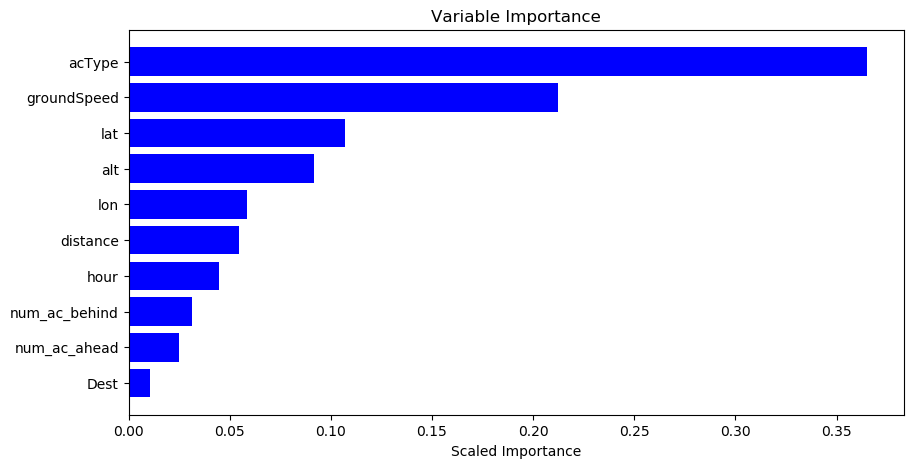

In [60]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,5))
variables = ac_gbm_down._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = ac_gbm_down._model_json['output']['variable_importances']['percentage']
ax.barh(y_pos, scaled_importance, align='center', color='blue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()
fig.savefig('VI_upper')

In [61]:
ac_gbm_up = H2OGradientBoostingEstimator(distribution = "quantile",quantile_alpha = 0.837, seed = 1234)
ac_gbm_up.train(x = predictors,
               y = response,
               training_frame = train,
               validation_frame = valid)

#print(ac_gbm.predict(valid))

# retrieve the model performance
#perf = ac_gbm.model_performance(valid)
pred_up = ac_gbm_up.predict(valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


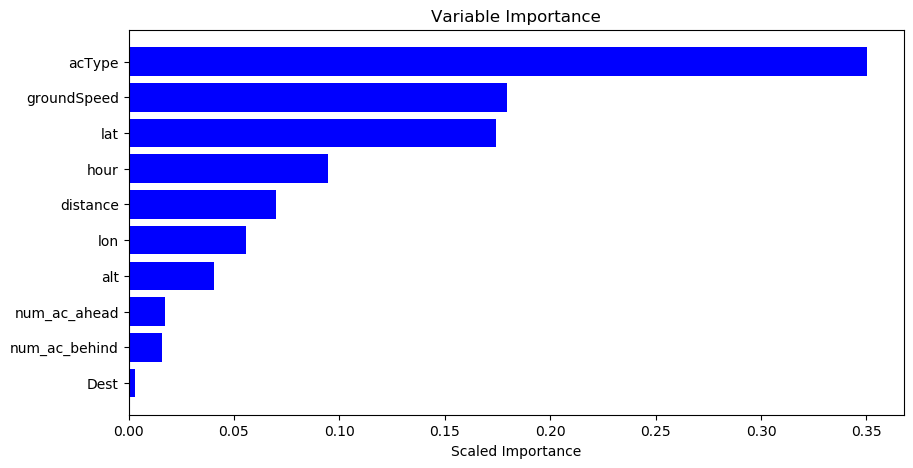

In [62]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,5))
variables = ac_gbm_up._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = ac_gbm_up._model_json['output']['variable_importances']['percentage']
ax.barh(y_pos, scaled_importance, align='center', color='blue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()
fig.savefig('VI_lower')

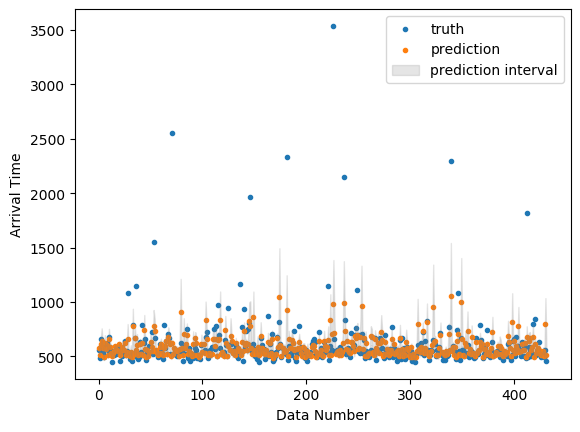

In [254]:
fig, ax= plt.subplots()
validpd = h2o.as_list(valid)
_ = range(valid.shape[0])
plt.scatter(_,validpd['arr_time'].tolist(), marker = '.', label='truth')

err_down = np.array(h2o.as_list(pred_low)['predict'])
err_up = np.array(h2o.as_list(pred_up)['predict'])

pred_m = (err_down+err_up)*0.5
_ = range(len(pred_m))
yerror = [err_down - pred_m, err_up-pred_m]
plt.scatter(_,pred_m, marker = '.', label='prediction')
#plt.errorbar(_, pred_new, yerr=yerror, fmt='k', elinewidth=None, capsize=5, barsabove=False, ls='none')
plt.fill_between(x, err_down, err_up, color='gray', alpha=0.2, label='prediction interval')
plt.legend()
plt.ylabel('Arrival Time')
plt.xlabel('Data Number')
fig.savefig('prediction')

In [64]:
yerror

[array([ -29.40065387,  -21.74947937,  -35.96560388, -111.7823125 ,
         -39.12947259,  -28.05533107,  -72.36026447,  -30.27063594,
         -44.83401151,  -30.77609748,  -91.54245605,  -59.05410137,
         -30.03630514,  -21.54684826,  -35.95680099,  -39.10705304,
         -18.67976557,  -17.55341215,  -46.67640914,  -29.59253384,
         -18.15824693,  -29.54812881,  -10.48462474,  -65.8202298 ,
         -46.52101227,  -23.59854903,  -22.7735452 ,  -37.70000652,
        -137.17408176,  -11.2449002 ,  -25.51451897,  -62.89702769,
         -12.78185921, -161.48245733,  -18.90245008,  -94.56738431,
         -69.34478832, -102.2243633 ,  -24.1512185 ,  -18.98703443,
         -44.41257154,  -22.27553605,  -40.24182734,  -20.05383782,
        -142.51222702,  -38.34386383,  -24.46127416,  -65.13835291,
         -17.58953179,  -18.05062949,  -69.41943365,  -90.1050351 ,
          -9.54184727, -149.20986623, -115.09047276,  -31.25109398,
         -20.23445026,   -8.47445163,  -25.10229

## implementation in the algorithm

In [65]:
slice_data_hf = h2o.H2OFrame(slice_data)
slice_pred_up = ac_gbm_up.predict(slice_data_hf)
slice_pred_down = ac_gbm_down.predict(slice_data_hf)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/home/pzhao28/anaconda3/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'acType' has levels not trained on: [CL60]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%


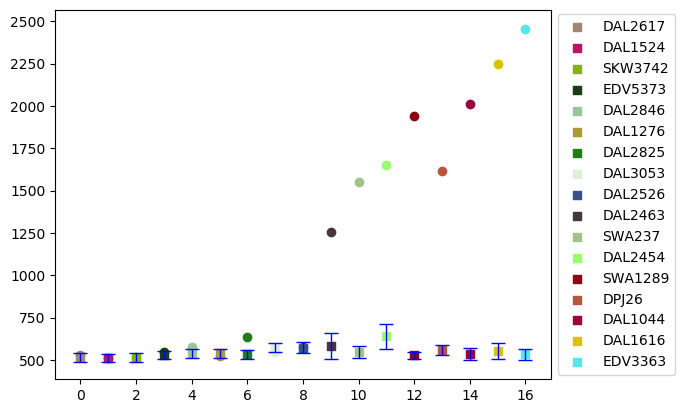

In [66]:
true_data = slice_data['arr_time'].values
err_pred_down = np.array(h2o.as_list(slice_pred_down)['predict'])
err_pred_up = np.array(h2o.as_list(slice_pred_up)['predict'])
slice_pred = (err_pred_down + err_pred_up)/2
_ = range(len(slice_pred))
yerror = [slice_pred - err_pred_down, err_pred_up-slice_pred]
plt.errorbar(_, slice_pred, yerr=yerror, fmt='b', elinewidth=1, capsize=5, barsabove=True, ls='none')

marker = ['o','s','v','^','D','<','>','h','H','p','*','8','P','d','X','x']
for i in range(len(true_data)):
    rgb = np.random.rand(3,)
    plt.scatter(_[i], slice_pred[i], marker='s', color=[rgb], label = slice_data['acId'].values[i])
    plt.scatter(_[i], true_data[i],marker='o', color = [rgb])
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

In [67]:
(err_pred_up -err_pred_down)/2

array([26.80038162, 22.99739784, 26.95960293, 23.09547016, 27.81931776,
       27.69191878, 26.16253664, 26.18761212, 32.34919737, 74.04045745,
       34.77523278, 74.90070666, 21.32017499, 30.37855469, 34.50249894,
       46.81124816, 33.19691438])

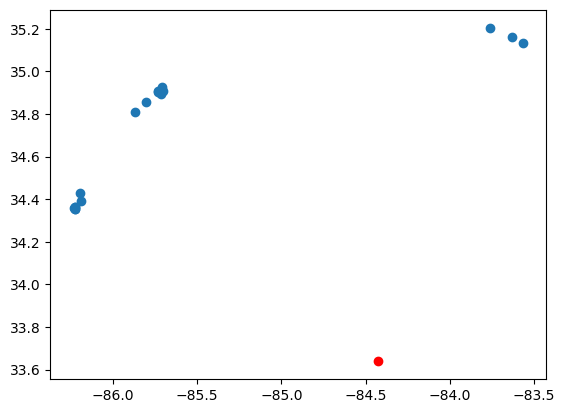

In [68]:
plt.scatter(slice_data['lon'].values, slice_data['lat'])
plt.scatter(airportsCoord['KATL'][1], airportsCoord['KATL'][0], color='r')

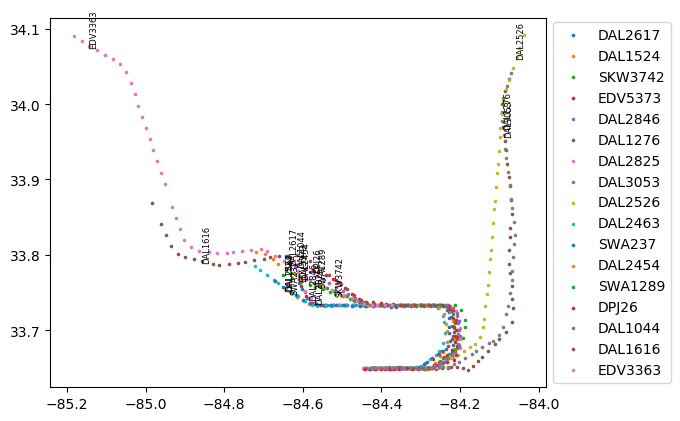

In [255]:
for index, row in slice_data.iterrows():
    id = row['acId']
    tr = pdf_rec3.loc[pdf_rec3['acId']==id]
    time = row['recTime']
    dest = row['Dest']
    tr = tr.loc[tr['recTime'].between(time,time+3000)]
    plt.scatter(tr['lon'][-50:], tr['lat'][-50:], marker = '.', s=10, label=id)
    j = np.random.randint(len(slice_data))
    plt.text(tr['lon'].values[-50+j//2],tr['lat'].values[-50+j//2], id, rotation='vertical',fontsize=6)
    #plt.scatter(airportsCoord[dest][1], airportsCoord[dest][0], marker = '*', color='r', s = 200)
    #for index, row in tr.iterrows():
        #distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord[dest][1], airportsCoord[dest][0])
        #if distance2airport<74080:
            #plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
            #break
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

In [70]:
'''runway1 = ['DAL2319', 'EDV5357', 'SKW3738', 'DAL2420']
runway2 = ['DAL1521']
runway3 = np.setdiff1d(slice_acId, runway1)
runway3 = np.setdiff1d(runway3, runway2)'''

"runway1 = ['DAL2319', 'EDV5357', 'SKW3738', 'DAL2420']\nrunway2 = ['DAL1521']\nrunway3 = np.setdiff1d(slice_acId, runway1)\nrunway3 = np.setdiff1d(runway3, runway2)"

In [71]:
#runway3 = ['SLI2710', 'DAL376', 'SKW5901', 'AAL1630', 'DAL2669', 'RPA4407', 'SWA2397','DAL2958', 'DAL1095','EDV5362', 'DAL2018']
#runway3 = ['AAL1630', 'DAL2669', 'DAL1095', 'EDV5362', 'EDV5484']
#runway3 = ['EDV3482', 'FFT1701', 'DAL1215', 'BTQ483', 'NKS808', 'DAL751']
#runway3 = ['SKW5901', 'DAL376', 'DAL2669','AAL1630', 'SWA2397', 'EDV5362', 'DAL1095', 'EDV5484', 'DAL2018']
runway3 = busy_runway1

### use runway3 as an example

In [224]:
from pyomo.environ import *
import numpy as np
import sys
from DistributionATSP import Distribution_ATSP
from scipy.stats import norm
import matplotlib.pyplot as plt
import random as rd
import pandas as pd

In [225]:
def time_space(threshold, sd1, sd2):
    return threshold - norm.ppf(q = Pc, loc = 0,scale = np.sqrt(sd1**2 + sd2**2))

In [226]:
Pc = 0.1
UB = [100000]
LB = [0]
tt = [0]
items = ['acId', 'threshold', 'mean', 'sd', 'uperBound', 'lowerBound']
ac = pd.DataFrame([], columns=items)
ac['acId'] = runway3
#ac['mean']= runway3_arr_time
ac.loc[:,'threshold'] = 60


In [227]:
r3_time = slice_data['recTime'].copy()
r3_time -= min(r3_time)
r3_time.values

array([0, 254, 349, 414, 566, 718, 626, 847, 1092, 665, 595, 774, 546,
       986, 846, 954, 1086], dtype=object)

In [228]:
#for id in slice_data['acId'].values:
    #check.append(id in runway3)
r3_pred = np.array(slice_pred)
#ac['mean'] = slice_data[check]['arr_time'].values

ac['mean'] = r3_pred + r3_time.values
ac['sd'] = np.array(err_pred_up) - r3_pred
ac['lowerBound'] = ac['mean'] - 60
ac['uperBound'] = ac['mean'] + 600

In [229]:
ac

,acId,threshold,mean,sd,uperBound,lowerBound
0,DAL2617,60,515.388,26.800382,1115.39,455.388
1,DAL1524,60,767.649,22.997398,1367.65,707.649
2,SKW3742,60,861.136,26.959603,1461.14,801.136
3,EDV5373,60,941.437,23.095470,1541.44,881.437
4,DAL2846,60,1105.78,27.819318,1705.78,1045.78
5,DAL1276,60,1256.46,27.691919,1856.46,1196.46
6,DAL2825,60,1158.84,26.162537,1758.84,1098.84
7,DAL3053,60,1421.95,26.187612,2021.95,1361.95
8,DAL2526,60,1663.78,32.349197,2263.78,1603.78
9,DAL2463,60,1247.43,74.040457,1847.43,1187.43


In [230]:
r3_pred

array([515.3881758 , 513.64881792, 512.13570234, 527.43704767,
       539.77678295, 538.46482267, 532.844766  , 574.95313393,
       571.7782764 , 582.42527367, 545.04961835, 639.28755599,
       527.19031955, 557.2303999 , 536.64212096, 553.09062254,
       534.06305813])

In [231]:
ac

,acId,threshold,mean,sd,uperBound,lowerBound
0,DAL2617,60,515.388,26.800382,1115.39,455.388
1,DAL1524,60,767.649,22.997398,1367.65,707.649
2,SKW3742,60,861.136,26.959603,1461.14,801.136
3,EDV5373,60,941.437,23.095470,1541.44,881.437
4,DAL2846,60,1105.78,27.819318,1705.78,1045.78
5,DAL1276,60,1256.46,27.691919,1856.46,1196.46
6,DAL2825,60,1158.84,26.162537,1758.84,1098.84
7,DAL3053,60,1421.95,26.187612,2021.95,1361.95
8,DAL2526,60,1663.78,32.349197,2263.78,1603.78
9,DAL2463,60,1247.43,74.040457,1847.43,1187.43


In [232]:
ac.loc[ac[ac['lowerBound']<0].index, 'lowerBound']=0

In [233]:
runway3 = slice_data['acId'].values
max_num = min(len(runway3), 8)
ac_runway3 = runway3[-max_num:]
ac_runway3

array(['DAL2463', 'SWA237', 'DAL2454', 'SWA1289', 'DPJ26', 'DAL1044',
       'DAL1616', 'EDV3363'], dtype=object)

In [234]:
check2 = []
for id in ac['acId'].values:
    check2.append(id in ac_runway3)
ac = ac[check2]


In [235]:
ac

,acId,threshold,mean,sd,uperBound,lowerBound
9,DAL2463,60,1247.43,74.040457,1847.43,1187.43
10,SWA237,60,1140.05,34.775233,1740.05,1080.05
11,DAL2454,60,1413.29,74.900707,2013.29,1353.29
12,SWA1289,60,1073.19,21.320175,1673.19,1013.19
13,DPJ26,60,1543.23,30.378555,2143.23,1483.23
14,DAL1044,60,1382.64,34.502499,1982.64,1322.64
15,DAL1616,60,1507.09,46.811248,2107.09,1447.09
16,EDV3363,60,1620.06,33.196914,2220.06,1560.06


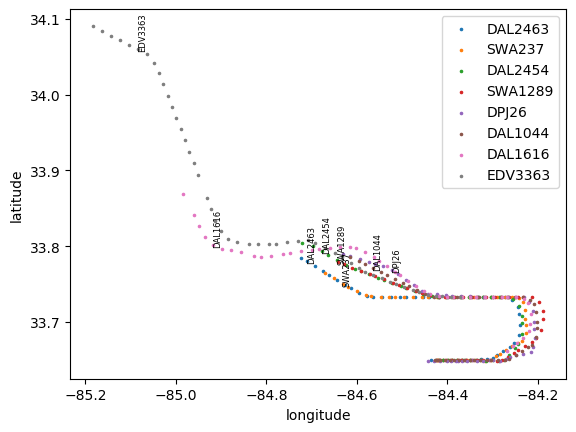

In [236]:
fig, ax = plt.subplots()
for index, row in slice_data.iterrows():
    id = row['acId']
    if id in ac_runway3:
        tr = pdf_rec3.loc[pdf_rec3['acId']==id]
        time = row['recTime']
        dest = row['Dest']
        tr = tr.loc[tr['recTime'].between(time,time+3000)]
        plt.scatter(tr['lon'][-50:], tr['lat'][-50:], marker = '.', s=10, label=id)
        j = np.random.randint(len(slice_data))
        plt.text(tr['lon'].values[-50+j//2],tr['lat'].values[-50+j//2], id, rotation='vertical',fontsize=6)
    #plt.scatter(airportsCoord[dest][1], airportsCoord[dest][0], marker = '*', color='r', s = 200)
    #for index, row in tr.iterrows():
        #distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord[dest][1], airportsCoord[dest][0])
        #if distance2airport<74080:
            #plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
            #break
plt.legend()
plt.xlabel('longitude')
plt.ylabel('latitude')
fig.savefig('landing_trj')

In [237]:
ac

,acId,threshold,mean,sd,uperBound,lowerBound
9,DAL2463,60,1247.43,74.040457,1847.43,1187.43
10,SWA237,60,1140.05,34.775233,1740.05,1080.05
11,DAL2454,60,1413.29,74.900707,2013.29,1353.29
12,SWA1289,60,1073.19,21.320175,1673.19,1013.19
13,DPJ26,60,1543.23,30.378555,2143.23,1483.23
14,DAL1044,60,1382.64,34.502499,1982.64,1322.64
15,DAL1616,60,1507.09,46.811248,2107.09,1447.09
16,EDV3363,60,1620.06,33.196914,2220.06,1560.06


In [238]:
ac = ac.reset_index(drop=True)

In [239]:
ac

,acId,threshold,mean,sd,uperBound,lowerBound
0,DAL2463,60,1247.43,74.040457,1847.43,1187.43
1,SWA237,60,1140.05,34.775233,1740.05,1080.05
2,DAL2454,60,1413.29,74.900707,2013.29,1353.29
3,SWA1289,60,1073.19,21.320175,1673.19,1013.19
4,DPJ26,60,1543.23,30.378555,2143.23,1483.23
5,DAL1044,60,1382.64,34.502499,1982.64,1322.64
6,DAL1616,60,1507.09,46.811248,2107.09,1447.09
7,EDV3363,60,1620.06,33.196914,2220.06,1560.06


In [240]:
tt = np.array([0])
tt = np.append(tt, np.array(ac['mean'].tolist()))
num_ac = len(ac_runway3)
for index, row in ac.iterrows():
    LB.append(row['lowerBound'])
    UB.append(row['uperBound'])
    tt_temp = [0]
    for ii in range(num_ac):
        if index == ii:
            space = 0
        else:
            space = time_space(row['threshold'], row['sd'], ac.loc[ii]['sd']) 
        tt_temp.append(space)
    tt=np.vstack((tt, np.array(tt_temp)))
N = num_ac
ccc = Distribution_ATSP(UB, LB, N, tt)
model = ccc.set_model()

solver = SolverFactory('glpk')
solution = solver.solve(model, tee=True)
result_time = np.zeros(N)
for i in range(N):
    result_time[i] = model.t[i+2].value
sort_index = np.argsort(result_time)
sort_time = np.sort(result_time)

GLPSOL: GLPK LP/MIP Solver, v4.57
Parameter(s) specified in the command line:
 --write /tmp/tmpn72swt4e.glpk.raw --wglp /tmp/tmp6lvcln4n.glpk.glp --cpxlp
 /tmp/tmpndnindog.pyomo.lp
Reading problem data from '/tmp/tmpndnindog.pyomo.lp'...
/tmp/tmpndnindog.pyomo.lp:1156: warning: lower bound of variable 'x11' redefined
/tmp/tmpndnindog.pyomo.lp:1156: warning: upper bound of variable 'x11' redefined
196 rows, 91 columns, 468 non-zeros
81 integer variables, all of which are binary
1237 lines were read
Writing problem data to '/tmp/tmp6lvcln4n.glpk.glp'...
956 lines were written
GLPK Integer Optimizer, v4.57
196 rows, 91 columns, 468 non-zeros
81 integer variables, all of which are binary
Preprocessing...
8 constraint coefficient(s) were reduced
90 rows, 81 columns, 344 non-zeros
72 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.317e+03  ratio =  1.317e+03
GM: min|aij| =  5.927e-01  max|aij| =  1.687e+00  ratio =  2.847e+00
EQ: min|aij| =  3.5

In [241]:
ttpd=pd.DataFrame(tt)
ttpd

,0,1,2,3,4,5,6,7,8
0,0.0,1247.425274,1140.049618,1413.287556,1073.190320,1543.230400,1382.642121,1507.090623,1620.063058
1,0.0,0.000000,164.831436,194.971811,158.742190,162.562932,164.683324,172.260423,163.987659
2,0.0,164.831436,0.000000,165.830344,112.275157,119.176237,122.779538,134.733356,121.612542
3,0.0,194.971811,165.830344,0.000000,159.802063,163.583719,165.683632,173.193791,164.994595
4,0.0,158.742190,112.275157,159.802063,0.000000,107.562770,111.977499,125.920138,110.561797
5,0.0,162.562932,119.176237,163.583719,107.562770,0.000000,118.913457,131.516428,117.668278
6,0.0,164.683324,122.779538,165.683632,111.977499,118.913457,0.000000,134.525451,121.360196
7,0.0,172.260423,134.733356,173.193791,125.920138,131.516428,134.525451,0.000000,133.545073
8,0.0,163.987659,121.612542,164.994595,110.561797,117.668278,121.360196,133.545073,0.000000


In [242]:
sort_time

array([1073.19031955, 1185.46547674, 1350.29691302, 1545.26872409,
       1710.95235621, 1829.86581301, 1947.53409144, 2081.07916454])

In [243]:
sort_index

array([3, 1, 0, 2, 5, 4, 7, 6])

In [244]:
ac = ac.reindex(sort_index)

In [245]:
marker = ['o','s','v','^','D','d','p','P']
#marker = ['o','s','v','^','D','<','>','h','H','p','*','8','P','d','X','x']
color = np.random.rand(8,3)
#ac_indicator = pd.DataFrame()
ac_indicator = ac[['acId']].copy()
ac_indicator['marker'] = marker
ac_indicator['color'] = color.tolist()
ac_indicator

,acId,marker,color
3,SWA1289,o,"[0.21192883621822656, 0.746078048392939, 0.6726119729423414]"
1,SWA237,s,"[0.13578644951589924, 0.14835213999911334, 0.17733791548179834]"
0,DAL2463,v,"[0.5531928260354066, 0.13798621742802375, 0.9340564810343278]"
2,DAL2454,^,"[0.03235914539062268, 0.36607826801473287, 0.07058594151125563]"
5,DAL1044,D,"[0.0926866760549705, 0.044086684902320594, 0.41193746628146066]"
4,DPJ26,d,"[0.8351437904705186, 0.0030714540171189464, 0.062300049215617714]"
7,EDV3363,p,"[0.21030573250191575, 0.13513664128457115, 0.3253315257626598]"
6,DAL1616,P,"[0.6323097334391932, 0.5765228234544275, 0.4126595377965271]"


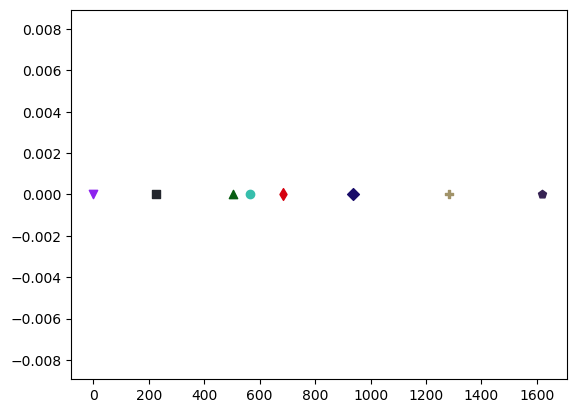

In [246]:
runway3_arr_time = []
for id in ac_runway3:
    arr_40_time = slice_data[slice_data['acId']==id]['recTime'].values[0] + slice_data[slice_data['acId']==id]['arr_time'].values[0]
    runway3_arr_time.append(arr_40_time)
i = 0
for id in ac_runway3:
    plt.scatter(np.array(runway3_arr_time)[i]-min(runway3_arr_time), 0, marker=ac_indicator[ac_indicator['acId']==id]['marker'].values[0], color=ac_indicator[ac_indicator['acId']==id]['color'].values)
    i+=1

In [247]:
land_time = []
time_40 = []
time_100 = []
time_200 = []
ac_runway3 = ac_indicator['acId'].values
for id in ac_runway3:
    land_time.append(slice_data.loc[slice_data['acId']==id]['land_t'].values[0])
    time_40.append(slice_data.loc[slice_data['acId']==id]['time40'].values[0])
    time_100.append(slice_data.loc[slice_data['acId']==id]['time100'].values[0])
    time_200.append(slice_data.loc[slice_data['acId']==id]['time200'].values[0])


In [248]:
ac_runway3

array(['SWA1289', 'SWA237', 'DAL2463', 'DAL2454', 'DAL1044', 'DPJ26',
       'EDV3363', 'DAL1616'], dtype=object)

In [249]:
ac_indicator['land_time'] = land_time
ac_indicator['time40'] = time_40
ac_indicator['time100'] = time_100
ac_indicator['time200'] = time_200
ac_indicator['sort_time'] = sort_time
#ac_indicator['sort_time'] = np.zeros(ac_indicator.shape[0])
#for i in range(ac_indicator.shape[0]):
#    ac_indicator.loc[i,'sort_time'] = sort_time[i]
ac_indicator

,acId,marker,color,land_time,time40,time100,time200,sort_time
3,SWA1289,o,"[0.21192883621822656, 0.746078048392939, 0.6726119729423414]",1564683506,1564682542,1564680604,1564679795,1073.190320
1,SWA237,s,"[0.13578644951589924, 0.14835213999911334, 0.17733791548179834]",1564683095,1564682205,1564680653,1564679855,1185.465477
0,DAL2463,v,"[0.5531928260354066, 0.13798621742802375, 0.9340564810343278]",1564682826,1564681978,1564680723,1564679915,1350.296913
2,DAL2454,^,"[0.03235914539062268, 0.36607826801473287, 0.07058594151125563]",1564683353,1564682481,1564680832,1564680047,1545.268724
5,DAL1044,D,"[0.0926866760549705, 0.044086684902320594, 0.41193746628146066]",1564683866,1564682914,1564680904,1564680119,1710.952356
4,DPJ26,d,"[0.8351437904705186, 0.0030714540171189464, 0.062300049215617714]",1564683569,1564682661,1564681044,1564680232,1829.865813
7,EDV3363,p,"[0.21030573250191575, 0.13513664128457115, 0.3253315257626598]",1564684521,1564683597,1564681144,1564680371,1947.534091
6,DAL1616,P,"[0.6323097334391932, 0.5765228234544275, 0.4126595377965271]",1564684152,1564683261,1564681012,1564680203,2081.079165


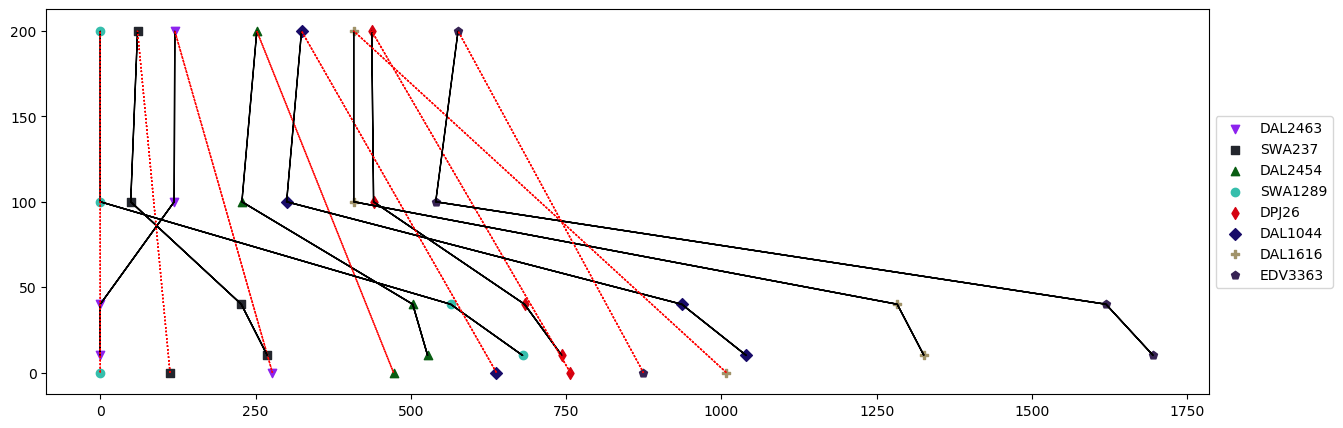

In [250]:
fig, ax = plt.subplots(figsize = (15,5))
for i in range(len(ac_runway3)):
    plt.scatter(ac_indicator['time200'][i]-min(ac_indicator['time200']), 200, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['time100'][i]-min(ac_indicator['time100']), 100, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['time40'][i]-min(ac_indicator['time40']), 40, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['land_time'][i]-min(ac_indicator['land_time']), 10, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['sort_time'][i]-min(ac_indicator['sort_time']), 0, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i], label = ac_indicator['acId'][i])
    ar0 = plt.arrow(ac_indicator['time200'][i]-min(ac_indicator['time200']), 200, ac_indicator['time100'][i]-min(ac_indicator['time100']) - (ac_indicator['time200'][i]-min(ac_indicator['time200'])), -100)
    ar1 = plt.arrow(ac_indicator['time100'][i]-min(ac_indicator['time100']), 100, ac_indicator['time40'][i]-min(ac_indicator['time40']) - (ac_indicator['time100'][i]-min(ac_indicator['time100'])), -60)
    ar2 = plt.arrow(ac_indicator['time40'][i]-min(ac_indicator['time40']), 40, ac_indicator['land_time'][i]-min(ac_indicator['land_time']) - (ac_indicator['time40'][i]-min(ac_indicator['time40'])), -30)                
    ar3 = plt.arrow(ac_indicator['time200'][i]-min(ac_indicator['time200']), 200, ac_indicator['sort_time'][i]-min(ac_indicator['sort_time']) - (ac_indicator['time200'][i]-min(ac_indicator['time200'])),-200,linestyle=':', color = 'r')

    ax.add_artist(ar1)
    ax.add_artist(ar2)
    ax.add_artist(ar3)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

In [251]:
first_acTime = min(ac_indicator['land_time'])
first_acTime

1564682826

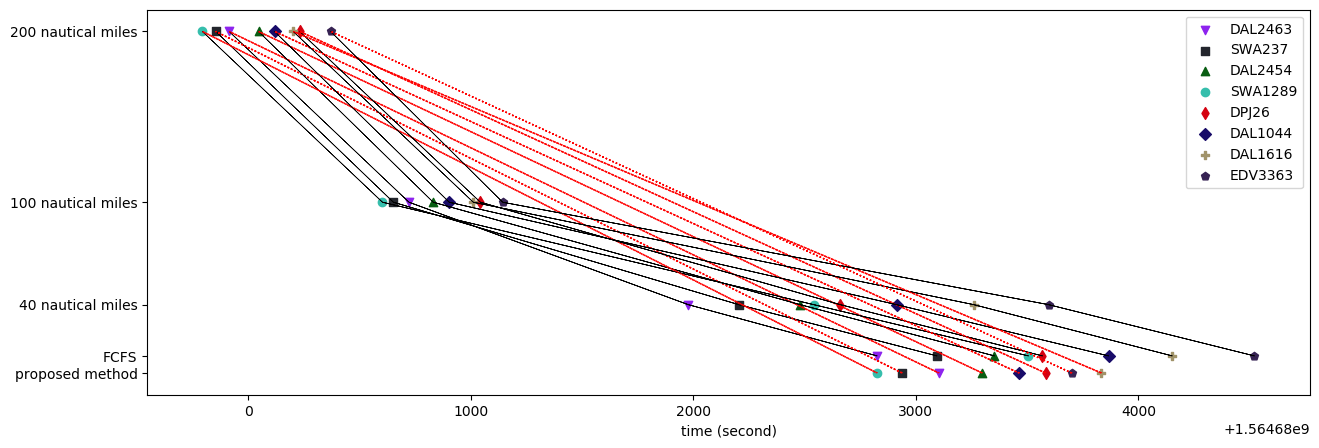

In [252]:
fig, ax = plt.subplots(figsize = (15,5))
bias = min(ac_indicator['land_time']) - min(ac_indicator['sort_time'])
for i in range(len(ac_runway3)):
    plt.scatter(ac_indicator['time200'][i], 200, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['time100'][i], 100, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['time40'][i], 40, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['land_time'][i], 10, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['sort_time'][i] + bias, 0, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i], label = ac_indicator['acId'][i])
    ar0 = plt.arrow(ac_indicator['time200'][i], 200, ac_indicator['time100'][i] - ac_indicator['time200'][i], -100, linewidth = 0.5)
    ar1 = plt.arrow(ac_indicator['time100'][i], 100, ac_indicator['time40'][i] - ac_indicator['time100'][i], -60, linewidth = 0.5)
    ar2 = plt.arrow(ac_indicator['time40'][i], 40, ac_indicator['land_time'][i]- ac_indicator['time40'][i], -30, linewidth = 0.5)                
    ar3 = plt.arrow(ac_indicator['time200'][i], 200, ac_indicator['sort_time'][i] + bias - ac_indicator['time200'][i],-200,linestyle=':', color = 'r')

    ax.add_artist(ar1)
    ax.add_artist(ar2)
    ax.add_artist(ar3)
plt.xlabel('time (second)')
#plt.ylabel('distance to destination (nautical mile)')
plt.legend()
#plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
y = [0, 10, 40, 100, 200]
yticks = ['proposed method', 'FCFS', '40 nautical miles', '100 nautical miles', '200 nautical miles']
plt.yticks(y, yticks, rotation = 'horizontal')
fig.savefig('result.png')

In [447]:
(sort_time - min(sort_time))*0.5

array([  0.        ,  52.40921208, 111.16474289, 169.72170672,
       223.51117539, 278.11359762, 349.50859804, 433.43030205])

In [448]:
jj = 0
for id in ac_runway3:
    init_index = pdf_rec3[pdf_rec3['acId'] == id].loc[pdf_rec3['init_ac']==True].index.values[0]
    end_index = pdf_rec3[pdf_rec3['acId'] == id].loc[pdf_rec3['end_ac']==True].index.values
    j = np.random.randint(len(slice_acId))
    if len(end_index) > 1:
        for i in end_index:
            if pdf_rec3.loc[i]['alt'] < pdf_rec3.loc[i-100]['alt']:
                tmp = i
        end_index = tmp
    else:
        end_index = end_index[0]
    if pdf_rec3.loc[end_index]['alt'] < 20:
        tt_lat = pdf_rec3[pdf_rec3['acId'] == id].loc[end_index-60:end_index]['lat']
        tt_lon = pdf_rec3[pdf_rec3['acId'] == id].loc[end_index-60:end_index]['lon']
        plt.scatter(tt_lon.values, tt_lat.values, marker=marker[jj], label=id, s=10, linewidths=1)
        plt.text(tt_lon.values[j//3],tt_lat.values[j//3], id, rotation='vertical',fontsize=6)
        jj+=1
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

NameError: name 'slice_acId' is not defined

In [372]:
from h2o.grid.grid_search import H2OGridSearch

# select the values for `quantile_alpha` to grid over
hyper_params = {'quantile_alpha': [.2, .5, .8]}

# this example uses cartesian grid search because the search space is small
# and we want to see the performance of all models. For a larger search space use
# random grid search instead: {'strategy': "RandomDiscrete"}
# initialize the GBM estimator
ac_gbm_2 = H2OGradientBoostingEstimator(distribution="quantile", seed = 1234,
                                              stopping_metric = "mse", stopping_tolerance = 1e-4)

# build grid search with previously made GBM and hyper parameters
grid = H2OGridSearch(model = ac_gbm_2, hyper_params = hyper_params,
                     search_criteria = {'strategy': "Cartesian"})

# train using the grid
grid.train(x = predictors, y = response, training_frame = train, validation_frame = valid)

# sort the grid models by decreasing MSE
sorted_grid = grid.get_grid(sort_by = 'mse', decreasing = False)
print(sorted_grid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
    quantile_alpha  \
0              0.5   
1              0.8   
2              0.2   

                                                        model_ids  \
0  Grid_GBM_py_121_sid_a626_model_python_1603474226017_94_model_2   
1  Grid_GBM_py_121_sid_a626_model_python_1603474226017_94_model_3   
2  Grid_GBM_py_121_sid_a626_model_python_1603474226017_94_model_1   

                  mse  
0  17903.484966387365  
1  18036.223071936613  
2  23687.845341320815  



In [373]:
valid[0,:]

time,partDay,acId,lat,lon,alt,Dest,acType,num_ac_ahead,num_ac_behind,arr_time
2019-06-24 00:55:03,0,DAL875,34.805,-83.0131,338,KATL,MD88,23,25,486


### sklearn

In [374]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import sklearn.model_selection as xval
from sklearn.datasets import fetch_openml
import forestci as fci

In [375]:
pdf3_dummy = pd.get_dummies(pdf3, columns=['Dest','acType'])

In [376]:
data = pdf3_dummy.drop(['time','acId'], axis=1)

In [377]:
features_df = data.drop(['arr_time'],axis=1)
feature_list = list(features_df.columns)
features = np.array(features_df)
labels = np.array(data['arr_time'])

In [378]:
train_features, test_features, train_labels, test_labels = xval.train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [379]:
n_trees = 2000
rf = RandomForestRegressor(n_estimators = n_trees, random_state = 42)
rf.fit(train_features, train_labels)
rf_pred = rf.predict(test_features)
rf_V_IJ_unbiased = fci.random_forest_error(rf, train_features, test_features, calibrate=True)

/home/pzhao28/anaconda3/lib/python3.7/site-packages/forestci/calibration.py:102: RuntimeWarning: invalid value encountered in true_divide
  g_eta_main = g_eta_raw / sum(g_eta_raw)


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]


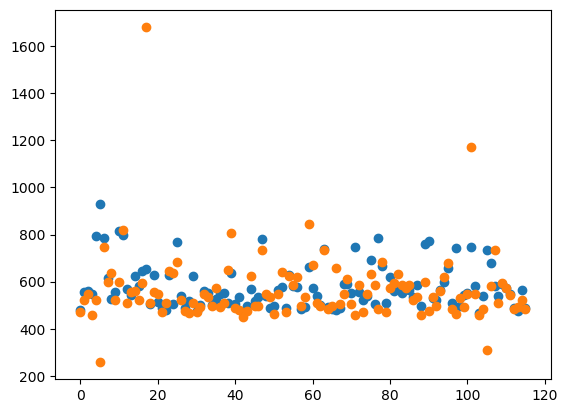

In [380]:
x = np.arange(0,len(rf_pred))
plt.scatter(x, rf_pred)
plt.scatter(x, test_labels)
print(rf_V_IJ_unbiased)
#plt.errorbar(test_labels, rf_pred, yerr=np.sqrt(rf_V_IJ_unbiased), fmt='o')

In [381]:
rf_pred

array([480.3005, 556.022 , 560.752 , 546.773 , 794.3075, 929.468 ,
       785.839 , 616.6245, 526.9835, 554.031 , 813.6095, 799.8925,
       566.731 , 543.624 , 623.95  , 580.6585, 646.153 , 653.008 ,
       504.66  , 629.6845, 514.305 , 488.0375, 480.7165, 627.3565,
       504.3965, 770.145 , 539.2215, 487.99  , 517.5475, 624.702 ,
       476.5465, 499.9445, 562.2195, 553.579 , 502.0865, 526.643 ,
       546.3915, 551.218 , 507.7175, 638.423 , 507.1385, 534.326 ,
       472.195 , 494.567 , 570.563 , 516.6055, 533.2275, 780.8315,
       539.9545, 488.6295, 494.7415, 565.6895, 578.23  , 486.427 ,
       629.4105, 579.594 , 575.522 , 484.688 , 493.7235, 660.08  ,
       572.119 , 539.5205, 500.682 , 740.1375, 492.4725, 485.2225,
       480.9175, 490.1455, 591.4765, 590.332 , 550.8045, 745.629 ,
       557.896 , 520.4425, 537.7145, 689.751 , 503.9905, 785.281 ,
       667.613 , 509.3435, 618.548 , 559.869 , 570.905 , 551.309 ,
       568.6875, 562.543 , 534.951 , 585.9615, 494.7085, 759.6

<ErrorbarContainer object of 3 artists>

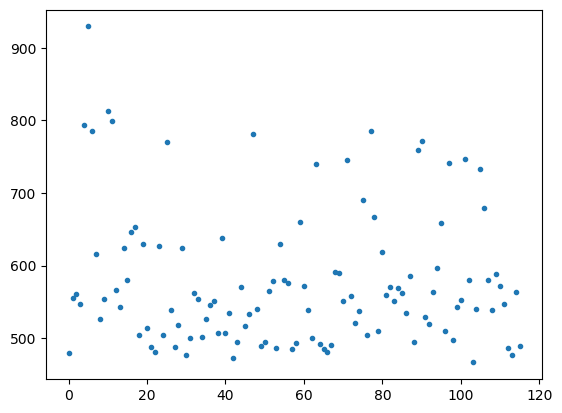

In [382]:
plt.errorbar(x, rf_pred, yerr=np.sqrt(rf_V_IJ_unbiased), fmt='.')

In [383]:
rf_V_IJ_unbiased

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [384]:
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict([X[x]]))
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

In [385]:
err_down, err_up = pred_ints(rf, test_features, percentile=100*(1-1e-6))

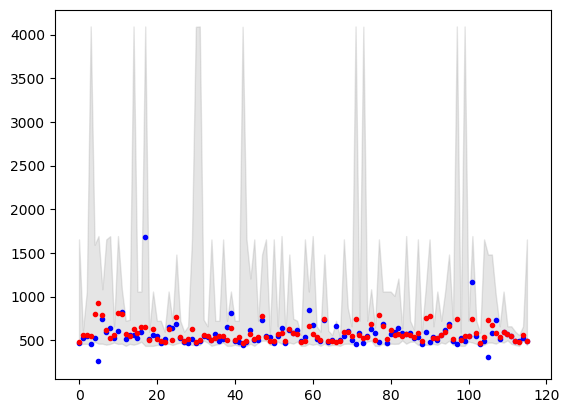

In [386]:
plt.fill_between(x, err_down, err_up, color='gray', alpha = 0.2)
plt.scatter(x, test_labels, marker = '.', color = 'b')
plt.scatter(x, rf_pred, marker = '.', color = 'r')

In [387]:
rf_most_important = RandomForestRegressor(n_estimators=1000, random_state = 42)

In [388]:
importances = rf.feature_importances_

In [389]:
importances

array([1.54217756e-02, 5.40374917e-02, 3.08951588e-01, 1.34309399e-01,
       4.14883008e-02, 2.92097968e-02, 1.62552249e-03, 7.08219239e-03,
       2.37626728e-03, 1.09824886e-03, 1.04113153e-05, 1.42675291e-04,
       9.10194089e-03, 5.87647779e-04, 2.74980715e-06, 1.08703882e-05,
       3.52933744e-03, 2.02272975e-03, 7.98057085e-04, 3.27604387e-04,
       1.68043438e-01, 5.96255303e-02, 0.00000000e+00, 2.82006507e-04,
       5.80124593e-05, 5.23222462e-05, 1.03174642e-04, 2.01209636e-05,
       5.84455041e-06, 1.22724700e-02, 0.00000000e+00, 8.90974147e-02,
       6.35482307e-05, 4.68033934e-06, 1.13111227e-03, 0.00000000e+00,
       8.46666882e-04, 5.22959781e-02, 5.03711114e-04, 9.10692009e-05,
       3.36127522e-05, 1.68997497e-04, 3.81436992e-04, 0.00000000e+00,
       1.32027036e-04, 7.22199071e-05, 2.65956052e-06, 3.38868318e-05,
       1.12735724e-04, 1.18521573e-04, 1.88113424e-05, 1.93643438e-03,
       3.56947919e-04])

([<matplotlib.axis.XTick at 0x7fd817934c50>,
 <a list of 53 Text xticklabel objects>)

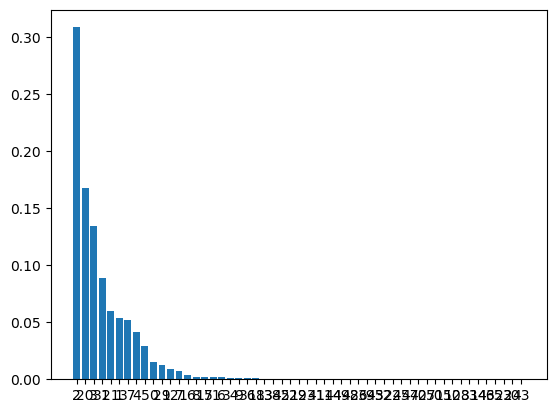

In [390]:
indices = np.argsort(importances)[::-1]
plt.bar(range(train_features.shape[1]), importances[indices], align='center')
plt.xticks(range(train_features.shape[1]), indices)

In [391]:
indices

array([ 2, 20,  3, 31, 21,  1, 37,  4,  5,  0, 29, 12,  7, 16,  8, 17, 51,
        6, 34,  9, 36, 18, 13, 38, 42, 52, 19, 23, 41, 11, 44, 49, 48, 26,
       39, 45, 32, 24, 25, 47, 40, 27, 50, 15, 10, 28, 33, 14, 46, 35, 22,
       30, 43])

In [392]:
feature_list

['partDay',
 'lat',
 'lon',
 'alt',
 'num_ac_ahead',
 'num_ac_behind',
 'Dest_KATL',
 'Dest_KCHA',
 'Dest_KGSP',
 'Dest_KHSV',
 'acType_A306',
 'acType_A319',
 'acType_A320',
 'acType_A321',
 'acType_A332',
 'acType_A333',
 'acType_B190',
 'acType_B712',
 'acType_B737',
 'acType_B738',
 'acType_B739',
 'acType_B744',
 'acType_B748',
 'acType_B752',
 'acType_B753',
 'acType_B763',
 'acType_B764',
 'acType_B77L',
 'acType_B77W',
 'acType_BE20',
 'acType_C172',
 'acType_C208',
 'acType_C525',
 'acType_C560',
 'acType_C680',
 'acType_C750',
 'acType_CRJ2',
 'acType_CRJ7',
 'acType_CRJ9',
 'acType_E135',
 'acType_E145',
 'acType_E170',
 'acType_E190',
 'acType_E45X',
 'acType_E545',
 'acType_E75L',
 'acType_E75S',
 'acType_EA50',
 'acType_F2TH',
 'acType_FA20',
 'acType_H25B',
 'acType_MD88',
 'acType_MD90']